<a href="https://colab.research.google.com/github/mariocsp/Project_AI_2023/blob/main/Tiny_VGG_for_Multi_feature_Timeline_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mengimport pustaka dan fungsi yang dibutuhkan

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchmetrics.functional import accuracy
from torch.nn import functional

from tqdm.auto import tqdm
from timeit import default_timer
from torchmetrics import ConfusionMatrix
from torchmetrics.classification import BinaryF1Score, BinaryPrecision
from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix

device = 'cuda' if torch.cuda.is_available() else "cpu"

# Load dan pengolahan data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/Shareddrives/AI/AI2023/hvcm/CCL'
features=['A+IGBT-I', 'A+*IGBT-I', 'B+IGBT-I', 'B+*IGBT-I', 'C+IGBT-I', 'C+*IGBT-I', 'A-FLUX',
         'B-FLUX', 'C-FLUX', 'MOD-V', 'MOD-I', 'CB-I', 'CB-V', 'DV/DT']

Mounted at /content/drive


In [ ]:
Y = np.load(f'{path}_labels.npy', allow_pickle=True)

In [ ]:
label_binary = Y[:,1]
label_multiclass = Y[:,2]

df_label = pd.DataFrame([label_binary,label_multiclass]).transpose()
df_label.columns = ['label_binary', 'label_multiclass']

label_binary = df_label['label_binary'] == 'Run'
label_binary = label_binary.astype(np.int32)

df_label['label_binary'] = label_binary
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   label_binary      2057 non-null   int32 
 1   label_multiclass  2057 non-null   object
dtypes: int32(1), object(1)
memory usage: 24.2+ KB


In [ ]:
X = np.load(f'{path}mnorm.npy')

### Normalisasi data menggunakan standardcaler

In [ ]:
"""
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = MinMaxScaler((0,255))
X_norm = np.zeros(X.shape)

for ind_i, i in enumerate(X):
  for j in range(14):
    feat = i[:,j].reshape(-1,1)
    scaler.fit(feat)
    trans = scaler.transform(feat)
    X_norm[ind_i,:,j] = np.int32(trans.squeeze())

np.save(path + 'mnorm.npy',X_norm)
"""
print()

### Scale data yang sudah dinormalisasi ke rentang 0-255 untuk gambar


In [ ]:
"""
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = StandardScaler()
X_norm = np.zeros(X.shape)

for ind_i, i in enumerate(X):
  for j in range(14):
    feat = i[:,j].reshape(-1,1)
    scaler.fit(feat)
    trans = scaler.transform(feat)
    X_norm[ind_i,:,j] = trans.squeeze()

np.save(path + 'snorm.npy', X_norm)
"""

print()

# Dataloader

### Menyeimbangkan frekuensi data normal dan anomaly

In [ ]:
np.random.seed(22)
Y_bin = label_binary.to_numpy()
fault_indices, normal_indices = np.where(Y_bin == 0)[0], np.where(Y_bin == 1)[0]

normal_indices = np.random.choice(normal_indices,size = 500)

Xnormal, Xanomaly = X[normal_indices,:,:], X[fault_indices,:,:]
Ynormal, Yanomaly = Y_bin[normal_indices], Y_bin[fault_indices]

In [ ]:
np.random.seed(22)
X_freq = np.concatenate((Xnormal,Xanomaly))
Y_freq = np.concatenate((Ynormal,Yanomaly))

X_train, X_test, y_train, y_test = train_test_split(X_freq, Y_freq, test_size=0.25, random_state=42)

### Mengubah data ke dalam format yang dapat dimasukan ke fungsi dataloader pytorch

In [ ]:
train_freq = []
for seq,label in zip(X_train,y_train):
  train_freq.append((np.float32([seq]),np.float32([label])))

In [ ]:
test_freq = []
for seq,label in zip(X_test,y_test):
  test_freq.append((np.float32([seq]),np.float32([label])))


Karena
 model yang akan digunakan adalah model vision maka terdapat 4 dimensi dalam dataloader yaitu [ukuran batch, kanal warna, tinggi gambar, lebar gambar]

ukuran batch yang kami gunakan adalah 32, Ukuran kanal yang kami gunakan adalah 1 karena data ini bukan merupakan data gambar melainkan data timeseries. Dimensi tinggi gambar adalah panjang timeseries yaitu 4500. Dimesi lebarnya adalah jumlah fitur yaitu 14. Tiap feature sudah discale ke rentang 0-255. Kedepannya kami ingin bereksperimen memisahkan fitur-fitur ke tiga kanal warna.

In [ ]:
BATCH = 32
train_freq_dataloader = DataLoader(train_freq,
                        batch_size = BATCH,
                        shuffle = True,
                        drop_last = True)

test_freq_dataloader = DataLoader(test_freq,
                             batch_size = BATCH,
                             shuffle = False,
                              drop_last = True)

# Mendefinisikan fungsi Untuk train dan evaluasi model

In [ ]:
def train_loop(model:torch.nn.Module,
               train_dataloader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.modules,
               optimizer: torch.optim.Optimizer,
               device:torch.device = device,
               scheduler=None):

  loss_train = 0
  acc_train = 0
  f1_train = 0
  prec_train = 0


  list_loss_train = []
  list_acc_train = []
  list_f1_train = []
  list_prec_train = []

  model.to(device)

  model.train()

  for batch, (X,y) in enumerate(train_dataloader):

    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad()

    logit = model(X)
    pred = torch.round(torch.sigmoid(logit))

    loss = loss_fn(logit,y)
    loss_train += loss
    loss.backward()
    optimizer.step()

    acc = accuracy(pred,y,task='binary').item()
    metric_f1 = BinaryF1Score().to(device)
    metric_prec = BinaryPrecision().to(device)
    f1 = metric_f1(pred,y).item()
    prec = metric_prec(pred,y).item()

    acc_train += acc
    f1_train += f1
    prec_train += prec

    list_loss_train.append(loss.item())
    list_acc_train.append(acc)
    list_f1_train.append(f1)
    list_prec_train.append(prec)


  if not scheduler == None:
    scheduler.step()

  pembagi_train = len(train_dataloader)
  loss_train = loss_train/pembagi_train
  acc_train = acc_train/pembagi_train
  f1_train = f1_train/pembagi_train
  prec_train = prec_train/pembagi_train


  dict_metrics = {"model": model.__class__.__name__,
                  "loss": loss_train.item(),
                  "akurasi": acc_train,
                  "F1":f1_train,
                  "presisi":prec_train}


  print(f"""
  __________Train___________
  loss: {loss_train.item():.5f}
  akurasi: {acc_train:.5f}
  F1 :{f1_train:.5f}
  presisi:{prec_train:.5f}
        """)

  return dict_metrics,list_loss_train,list_acc_train,list_f1_train, list_prec_train

In [ ]:
def model_metrics(model:torch.nn.Module,
                  test_dataloader:torch.utils.data.DataLoader,
                  loss_fn: torch.nn.modules):

  model.to(device)
  model.eval()

  list_loss_test = []
  list_acc_test = []
  list_f1_test = []
  list_prec_test = []

  loss_test = 0
  acc_test = 0
  f1_test = 0
  prec_test = 0

  with torch.inference_mode():

    for batch, (X,y) in enumerate(test_dataloader):
      X = X.to(device)
      y = y.to(device)

      logit = model(X)
      loss = loss_fn(logit,y)

      loss_test += loss
      pred = torch.round(torch.sigmoid(logit))

      acc = accuracy(pred,y,task='binary').item()
      metric_f1 = BinaryF1Score().to(device)
      metric_prec = BinaryPrecision().to(device)
      f1 = metric_f1(pred,y).item()
      prec = metric_prec(pred,y).item()

      acc_test += acc
      f1_test += f1
      prec_test += prec

      list_loss_test.append(loss.item())
      list_acc_test.append(acc)
      list_f1_test.append(f1)
      list_prec_test.append(prec)

    pembagi_test = len(test_dataloader)

    loss_test = loss_test/pembagi_test
    acc_test = acc_test/pembagi_test
    f1_test = f1_test/pembagi_test
    prec_test = prec_test/pembagi_test


  dict_metrics = {"model": model.__class__.__name__,
                  "loss": loss_test.item(),
                  "akurasi": acc_test,
                  "F1" :f1_test,
                  'presisi':prec_test}

  print(f"""

  _________Test______________
  loss: {loss_test.item():.5f}
  akurasi: {acc_test:.5f}
  F1 :{f1_test:.5f}
  presisi:{prec_test:.5f}
        """)

  return dict_metrics, list_loss_test, list_acc_test,list_f1_test, list_prec_test

In [ ]:
def manual_tensorboard(dict_info:dict):
  fig, axs = plt.subplots(3,3)
  fig.set_figheight(12)
  fig.set_figwidth(12)

  for j,i in enumerate(dict_info):
    value = dict_info[i]
    x = np.linspace(0,100,len(value))
    fig.add_subplot(3, 3, j+ 1 )
    plt.plot(x,value)
    plt.xlabel('Time (s)')
    plt.title(i)
    plt.xticks([])
    plt.yticks([])
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

  fig.show()

  return True


In [ ]:
def confusion_metric(model, dataloader):
  y_preds = []
  labels = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(dataloader, desc="Making predictions"):
      X, y = X.to(device), y.to(device)
      y_logit = model(X)
      y_pred = torch.round(torch.sigmoid(y_logit))
      y_preds.append(y_pred.cpu())
      labels.append(y.cpu())

    y_pred_tensor = torch.cat(y_preds)
    labels = torch.cat(labels)

    confmat = ConfusionMatrix(num_classes=2, task='binary')
    confmat_tensor = confmat(preds=y_pred_tensor,
                         target=labels)
    # 3. Plot the confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
        figsize=(10, 7)
        );

    return True


# Struktur dan Inisialisasi Model

Model yang kami gunakan adalah model tiny VGG dengan ukuran kernel=5 dan jumlah hidden nodes 32. Alasan kami memilih model ini adalah karena model ini merupakan salah satu model vision yang cukup sederhana, menurut kami model ini cukup untuk melakukan klasifikasi pada representasi data timeseries dengan waktu training yang relatif cepat.

In [ ]:
class ModelVision(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_nodes:int,
               output_shape:int):
    super().__init__()

    self.block2 = nn.Sequential(nn.Conv2d(in_channels=hidden_nodes,
                                          out_channels=hidden_nodes,
                                          kernel_size=5,
                                          stride=1,
                                          padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2,
                                              stride=2))

    self.block1 = nn.Sequential (nn.Conv2d(in_channels=input_shape,
                                          out_channels=hidden_nodes,
                                          kernel_size=5,
                                          stride=1,
                                          padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(in_channels=hidden_nodes,
                                          out_channels=hidden_nodes,
                                          kernel_size=5,
                                          stride=1,
                                          padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2,
                                              stride=2))


    self.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(in_features=hidden_nodes*1123,
                                              out_features=output_shape))
  def forward(self,x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.classifier(x)
    return x

In [ ]:
torch.manual_seed(22)
model_vis = ModelVision(1,32,1)
print(model_vis)

ModelVision(
  (block2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=71872, out_features=1, bias=True)
  )
)


# Training Model

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params = model_vis.parameters(),lr = 0.0000075)#,weight_decay = 0.0001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,
                                               start_factor=0.3333333333333333,
                                               end_factor=1.0, total_iters=25,
                                               last_epoch=- 1, verbose=True)

print(type(loss_fn))
print(type(optimizer))
print(type(scheduler))

Adjusting learning rate of group 0 to 2.5000e-06.
<class 'torch.nn.modules.loss.BCEWithLogitsLoss'>
<class 'torch.optim.adam.Adam'>
<class 'torch.optim.lr_scheduler.LinearLR'>


In [ ]:
epochs = 130

dict_info = {'loss_train':[],
             'acc_train':[],
             'F1_train':[],
             'prec_train':[],
             'loss_test':[],
             'acc_test':[],
             'F1_test':[],
             'prec_test':[]}

for epoch in range(epochs+1):
  print(f"epoch--{epoch}\n________")
  log_train,l,a,F1,p = train_loop(model_vis,
                         train_freq_dataloader,
                         loss_fn,
                         optimizer,
                         device,
                         scheduler)

  dict_info['loss_train'] = dict_info['loss_train'] + l
  dict_info['acc_train'] = dict_info['acc_train'] + a
  dict_info['F1_train'] = dict_info['F1_train'] + F1
  dict_info['prec_train'] = dict_info['prec_train'] + p

  if epoch%(epochs//10) == 0:
    log_test,lt,at,F1t,pt = model_metrics(model_vis,test_freq_dataloader,loss_fn)

    dict_info['loss_test'] = dict_info['loss_test'] + lt
    dict_info['acc_test'] = dict_info['acc_test'] + at
    dict_info['F1_test'] = dict_info['F1_test'] + F1t
    dict_info['prec_test'] = dict_info['prec_test'] + pt



# Evaluasi Model

In [ ]:

torch.save(model_vis.state_dict(),path + "vis_uas.pth")

print('run only when you get good result')

run only when you get good result


In [ ]:
model_vis_inf = ModelVision(1,64,1)

state = torch.load(path + "vis_uas.pth")
model_vis_inf.load_state_dict(state)

<All keys matched successfully>

Making predictions:   0%|          | 0/6 [00:00<?, ?it/s]

True

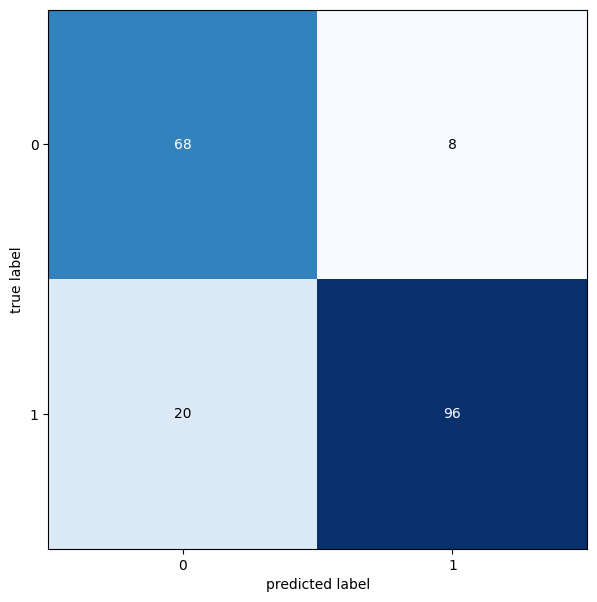

In [ ]:
confusion_metric(model_vis_inf,test_freq_dataloader)

Making predictions:   0%|          | 0/18 [00:00<?, ?it/s]

True

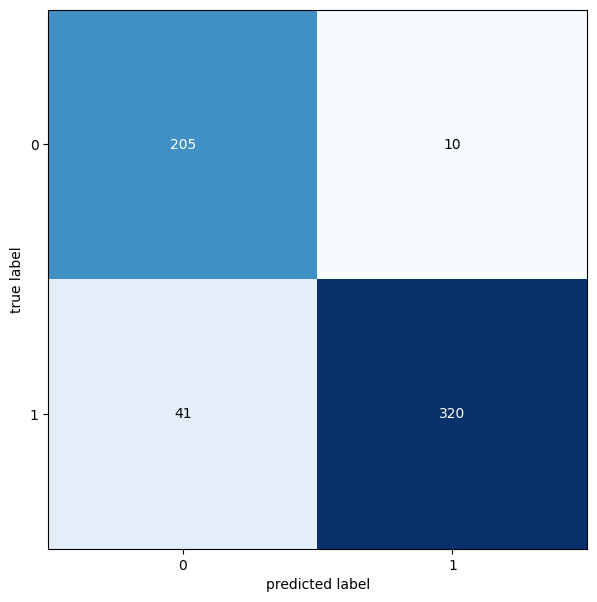

In [ ]:
confusion_metric(model_vis_inf,train_freq_dataloader)

In [ ]:
manual_tensorboard(dict_info)

In [ ]:
log_train

{'model': 'ModelVision',
 'loss': 0.21625269949436188,
 'akurasi': 0.8940972222222222,
 'F1': 0.9086135493384467,
 'presisi': 0.933796250157886}

In [ ]:
log_test

{'model': 'ModelVision',
 'loss': 0.3205312490463257,
 'akurasi': 0.8385416666666666,
 'F1': 0.8612178762753805,
 'presisi': 0.8843253950277964}